In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [ ]:

np.random.seed(42)
n_assets = 4
n_samples = 1000


expected_returns = np.array([0.10, 0.08, 0.13, 0.07])


cov_matrix = np.array([
    [0.0045, 0.0010, 0.0009, 0.0003],
    [0.0010, 0.0030, 0.0015, 0.0006],
    [0.0009, 0.0015, 0.0050, 0.0004],
    [0.0003, 0.0006, 0.0004, 0.0020]
])

weights = np.random.dirichlet(np.ones(n_assets), size=n_samples)

portfolio_returns = weights @ expected_returns

In [ ]:
def portfolio_variance(weights, cov_matrix):
    return weights.T @ cov_matrix @ weights

In [ ]:
def portfolio_semivariance(weights, cov_matrix, target_return=0):
    portfolio_return = weights @ expected_returns
    downsides = portfolio_returns - target_return
    semivariance = np.mean(np.square(np.minimum(downsides, 0)))
    return semivariance


In [ ]:
def portfolio_cvar(weights, cov_matrix, alpha=0.05):
    portfolio_return = weights @ expected_returns
    simulated_returns = np.random.multivariate_normal(expected_returns, cov_matrix, size=10000)
    portfolio_sim_returns = simulated_returns @ weights
    VaR = np.percentile(portfolio_sim_returns, 100 * alpha)
    CVaR = portfolio_sim_returns[portfolio_sim_returns <= VaR].mean()
    return CVaR


In [ ]:
def objective_function(weights, cov_matrix, expected_returns, risk_func, risk_weight, return_weight):
    risk = risk_func(weights, cov_matrix)
    portfolio_return = weights @ expected_returns
    return risk_weight * risk - return_weight * portfolio_return


In [ ]:
constraints = (
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
)
bounds = tuple((0, 1) for _ in range(n_assets))


def optimize_portfolio(risk_func, risk_weight=1, return_weight=1):
    x0 = np.array(n_assets * [1. / n_assets])
    result = minimize(
        objective_function,
        x0,
        args=(cov_matrix, expected_returns, risk_func, risk_weight, return_weight),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        optimized_weights = result.x
        optimized_risk = risk_func(optimized_weights, cov_matrix)
        optimized_return = optimized_weights @ expected_returns
        return optimized_weights, optimized_risk, optimized_return
    else:
        raise BaseException(result.message)

In [ ]:
def find_pareto_front(risk_func, risk_weight_range, return_weight_range):
    pareto_risks = []
    pareto_returns = []
    pareto_weights = []
    for w in range(len(risk_weight_range)):
        risk_weight = risk_weight_range[w]
        return_weight = return_weight_range[w]
        weights, risk, ret = optimize_portfolio(risk_func, risk_weight, return_weight)
        pareto_risks.append(risk)
        pareto_returns.append(ret)
        pareto_weights.append(weights)
    return pareto_risks, pareto_returns, pareto_weights

In [ ]:
weight_range = np.linspace(0, 1, 50)
risk_weight_range = weight_range
return_weight_range = 1 - weight_range
selected_risk_func = portfolio_variance
pareto_risks, pareto_returns, pareto_weights = find_pareto_front(
    selected_risk_func,
    risk_weight_range,
    return_weight_range
)

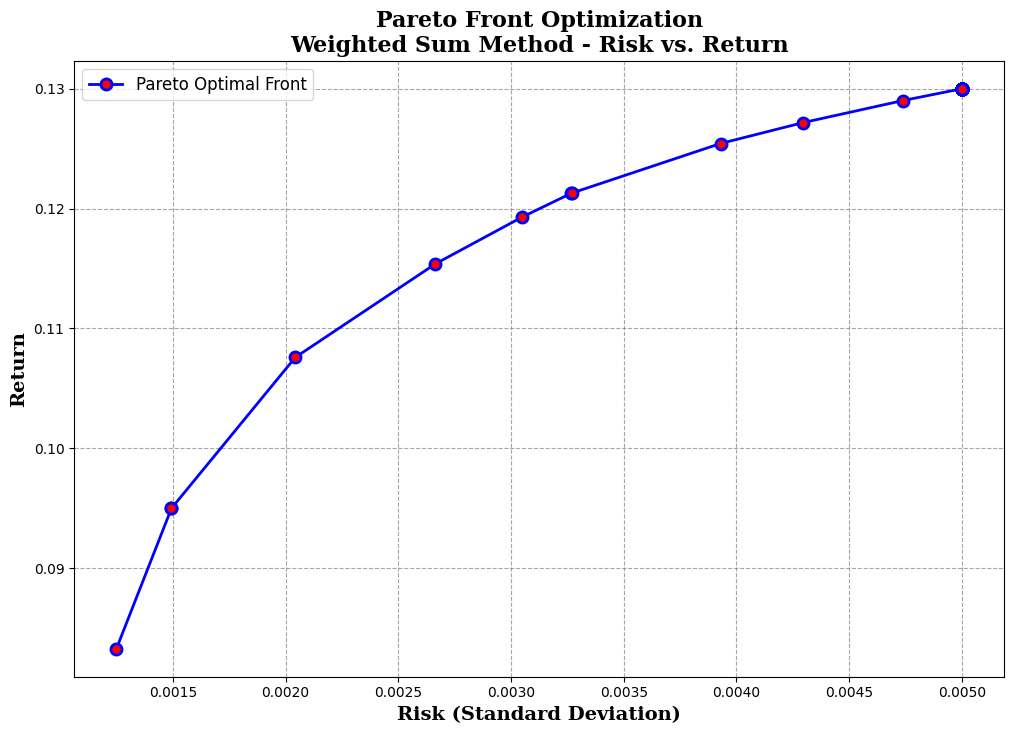

Pareto Optimal Weights, Risks, and Returns:
        Asset 1       Asset 2  Asset 3       Asset 4   Risk  Return
0  6.661338e-16  0.000000e+00      1.0  0.000000e+00  0.005    0.13
1  1.249001e-16  0.000000e+00      1.0  0.000000e+00  0.005    0.13
2  5.412337e-16  6.383782e-16      1.0  0.000000e+00  0.005    0.13
3  0.000000e+00  1.977585e-16      1.0  7.632783e-17  0.005    0.13
4  3.330669e-16  0.000000e+00      1.0  0.000000e+00  0.005    0.13


In [ ]:

plt.figure(figsize=(12, 8))


plt.plot(pareto_risks, pareto_returns, 'bo-', markersize=8, linewidth=2, markerfacecolor='red', markeredgewidth=2)


plt.xlabel('Risk (Standard Deviation)', fontsize=14, fontweight='bold', family='serif')
plt.ylabel('Return', fontsize=14, fontweight='bold', family='serif')

plt.title('Pareto Front Optimization\nWeighted Sum Method - Risk vs. Return', fontsize=16, fontweight='bold', family='serif')


plt.grid(True, linestyle='--', color='gray', alpha=0.7)


plt.legend(['Pareto Optimal Front'], loc='upper left', fontsize=12)


plt.show()


pareto_table = pd.DataFrame(pareto_weights, columns=[f'Asset {i+1}' for i in range(len(pareto_weights[0]))])
pareto_table['Risk'] = pareto_risks
pareto_table['Return'] = pareto_returns


print("Pareto Optimal Weights, Risks, and Returns:")
print(pareto_table.head())

In [ ]:
X = np.linspace(0, 100, 400)
Y = np.linspace(0, 100, 400)
X, Y = np.meshgrid(X, Y)
constraint1 = X + 2*Y <= 100
constraint2 = 3*X + Y <= 90
non_negativity = (X >= 0) & (Y >= 0)
feasible = constraint1 & constraint2 & non_negativity

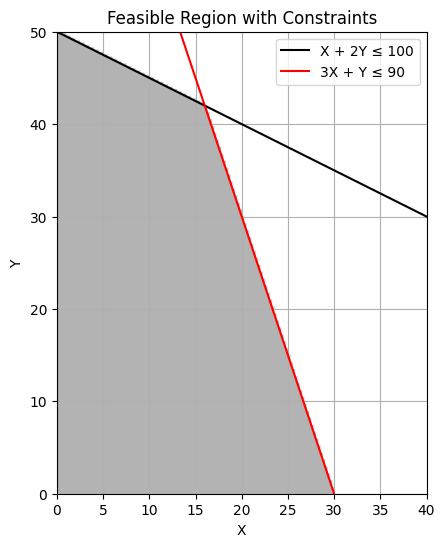

In [ ]:
plt.figure(figsize=(8, 6))

# Plot feasible region
plt.imshow(feasible.astype(int), extent=(0, 100, 0, 100), origin='lower', cmap='Greys', alpha=0.3)


y1 = (100 - X) / 2
plt.plot(X[0], y1[0], label='X + 2Y ≤ 100', color='black')


y2 = (90 - 3*X) / 1
plt.plot(X[0], y2[0], label='3X + Y ≤ 90', color='red')



plt.xlim(0, 40)
plt.ylim(0, 50)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Feasible Region with Constraints')
plt.legend()
plt.grid(True)
plt.show()